# Tidal Triggering of Seismicity near Hawaii Island

### Research Question: Are ocean tides triggering seismic events near the Big Island of Hawaii?

#### Abstract:
##### Tidal triggering of seismicity is the occurrence of seismic events in phase with and triggered by the transmission of solid Earth tides through the lithosphere or ocean tides through the ocean. The effect is well studied and corroborated near subduction zones, but has consistently failed to be detected near transverse or divergent plate margins. Near subduction zones, seismic events occur in phase with lower ocean tides, as the weight of the overriding water acts as a clamp preventing megathrust earthquakes. Since megathrust earthquakes involve the displacement of overriding water by a rebounding plate, the lesser weight of the overriding water at low tide corresponds to an increased occurrence of earthquakes. In this study, I will test for a tidally triggered component of seismic events in a new geological regime: near the Hawaiian Islands, where seismic activity is caused by a mantle plume hotspot penetrating Earth's crust. Since the lithosphere under the Hawaiian Islands is isostatically rebounding as the Hawaiian Islands erode, a decrease in water weight opposing that rebound may allow for more rebound at low tide, and potentially more seismic activity.

#### Personal Motivation:
##### I intend to study tidally triggered seismicity in the Sunda Trench off the southern coast of Java, Indonesia next year.

In [1]:
#imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from matplotlib import colorbar, colors
import matplotlib.gridspec as gs
from scipy.stats import norm

### 1) Data Acquisition
##### Seismic data is USGS ComCat data retrieved from the UC Berkeley's Northern California Earthquake Data Center. Data was selected on the NCEDC website to include only events around Hawaii and only events from 2000-2005.
##### Tide data is retrieved from the University of Hawaii Sea Level Center's Tide Database. Two tide stations were chosen: Kawaihae, on the Big Island's western coast, and Hilo, on its eastern coast.

In [2]:
# Load Seismic Data
Hawaii_events = pd.read_csv('catsearch.6113')
# Convert time to datetime object
Hawaii_events['DateTime'] = pd.to_datetime(Hawaii_events['DateTime']) 

# Load Tidal Data
Kawaihae_tide_data = pd.read_csv('http://uhslc.soest.hawaii.edu/data/csv/rqds/pacific/hourly/h552a.csv')
Hilo_tide_data = pd.read_csv('http://uhslc.soest.hawaii.edu/data/csv/rqds/pacific/hourly/h059a.csv')

### 2) Data Cleanup
##### Time key for seismic data was converted to datetime object, and set as the dataframe index.
##### Tide data was filtered to include only the period from 2000-2005 (representing the longest period of continuous data common to all three data sets). "Year," "Month," "Day," and "Hour" keys were concatenated into a single datetime object, which was set as the dataframe index.

In [3]:
#Define time keys for Kawaihae Tide Data
Kawaihae_tide_data['year'] = Kawaihae_tide_data.pop('1989')
Kawaihae_tide_data['month'] = Kawaihae_tide_data.pop('3')
Kawaihae_tide_data['day'] = Kawaihae_tide_data.pop('1')
Kawaihae_tide_data['hour'] = Kawaihae_tide_data.pop('0')
Kawaihae_tide_data['Tide Height (MLLW)'] = Kawaihae_tide_data.pop('930')

# Select study period from 2000-2005
Kawaihae_tide_data14on = Kawaihae_tide_data[Kawaihae_tide_data.year > 1999]           
Kawaihae_tide_data14 = Kawaihae_tide_data14on[Kawaihae_tide_data14on.year < 2006]

#Define time keys for Kawaihae Tide Data
Hilo_tide_data['year'] = Hilo_tide_data.pop('1950')
Hilo_tide_data['month'] = Hilo_tide_data.pop('10')
Hilo_tide_data['day'] = Hilo_tide_data.pop('19')
Hilo_tide_data['hour'] = Hilo_tide_data.pop('2')
Hilo_tide_data['Tide Height (MLLW)'] = Hilo_tide_data.pop('1006')

# Select study period from 2000-2005
Hilo_tide_data14on = Hilo_tide_data[Hilo_tide_data.year > 1999]
Hilo_tide_data14 = Hilo_tide_data14on[Hilo_tide_data14on.year < 2006]

In [4]:
#Concatenate time keys into single datetime key
Kawaihae_tide_data14['time'] = pd.to_datetime(Kawaihae_tide_data14[['hour','day','month','year']])
Hilo_tide_data14['time'] = pd.to_datetime(Hilo_tide_data14[['hour','day','month','year']])

#Delete Redundant Keys
del Kawaihae_tide_data14['year']
del Kawaihae_tide_data14['month']
del Kawaihae_tide_data14['day']
del Kawaihae_tide_data14['hour']

del Hilo_tide_data14['year']
del Hilo_tide_data14['month']
del Hilo_tide_data14['day']
del Hilo_tide_data14['hour']

# Set index to time key
Kawaihae_tide_data14 = Kawaihae_tide_data14.set_index('time')
Hilo_tide_data14 = Hilo_tide_data14.set_index('time')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### 3) Filter for oceanic seismic events

#### Cartopy Shapereader and Shapely Geometry were imported to allow for the selection of only events that occurred beneath the ocean. An 'is_land' function was defined to allow for the determination of whether the latitude and longitude coordinates of the seismic events corresponded to land or water. Data was filtered to include oceanic events only.

In [5]:
# Imports
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep

# Import natural_earth data for comparison
land_shp_fname = shpreader.natural_earth(resolution='10m',
                                   category='physical', name='land')

land_geom = unary_union(list(shpreader.Reader(land_shp_fname).geometries()))
land = prep(land_geom)

# Define is_land function
def is_land(x, y):
       return land.contains(sgeom.Point(x, y))

In [6]:
# Convert lat/lon pd arrays to base python lists to pass to is_land function
HE_latitude = Hawaii_events.Latitude.tolist()
HE_longitude= Hawaii_events.Longitude.tolist()

In [7]:
# Pass latitude data to is_land function
n = Hawaii_events.Latitude.size
land_boolean = []
for x in range(n):
    y = is_land(HE_longitude[x], HE_latitude[x])
    land_boolean.append(y)

In [8]:
# Append land_boolean to Dataframe
Hawaii_events['Land'] = land_boolean

In [9]:
# Select only Submarine Seismic 
Hawaii_ocean_events = Hawaii_events[Hawaii_events.Land == False]

# Define "Hilo" and "Kona" study area seismic events
BI_ocean_eventsN = Hawaii_ocean_events[Hawaii_ocean_events.Latitude < 20.5]
BI_ocean_eventsE = BI_ocean_eventsN[BI_ocean_eventsN.Latitude > 18.5]
BI_ocean_events = BI_ocean_eventsE[BI_ocean_eventsN.Longitude > -157]
Hilo_ocean_events = BI_ocean_events[BI_ocean_events.Longitude > -155.6]
Kona_ocean_eventsW = BI_ocean_events[BI_ocean_events.Longitude < -155.6]
Kona_ocean_events = Kona_ocean_eventsW[Kona_ocean_eventsW.Longitude > -157]

# Set Index to time
Kona_ocean_events['time'] = Kona_ocean_events.pop('DateTime')
Hilo_ocean_events['time'] = Hilo_ocean_events.pop('DateTime')

Kona_ocean_events = Kona_ocean_events.set_index('time')
Hilo_ocean_events = Hilo_ocean_events.set_index('time')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### 4) Visualize selected data and study areas.

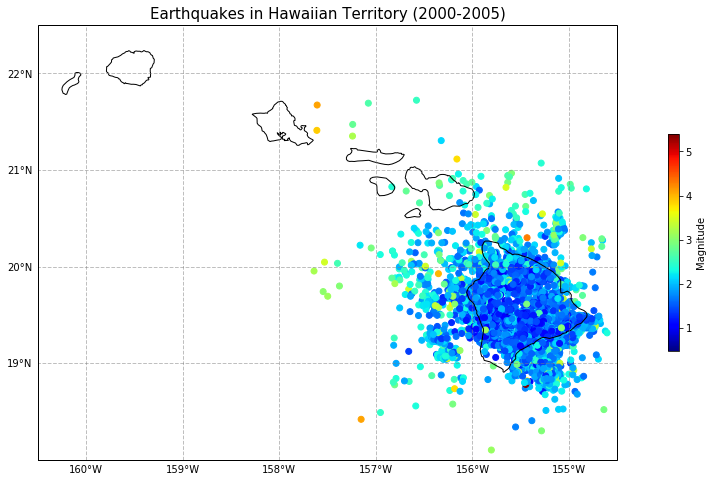

In [10]:
# Visualize All Hawaiian Earthquakes 2000-2005

fig, axes = plt.subplots(figsize=(18, 8), ncols=5, sharey = True)
ax = plt.axes(projection=ccrs.PlateCarree())
extent = [-160.5, -154.5, 18, 22.5]
ax.set_extent(extent)
ax.set_xlabel('Longitude')
ax.set_title('Earthquakes in Hawaiian Territory (2000-2005)', size=15)
ax.coastlines(resolution='10m')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels = True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator([-161, -160, -159, - 158, -157, -156, -155, -154])
gl.ylocator = mticker.FixedLocator([18, 19, 20, 21, 22, 23])
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

gl1 = ax.scatter(Hawaii_events.Longitude, Hawaii_events.Latitude, c=Hawaii_events.Magnitude, cmap='jet', transform=ccrs.PlateCarree())

h = plt.colorbar(gl1, shrink=0.5)
h.set_label('Magnitude')

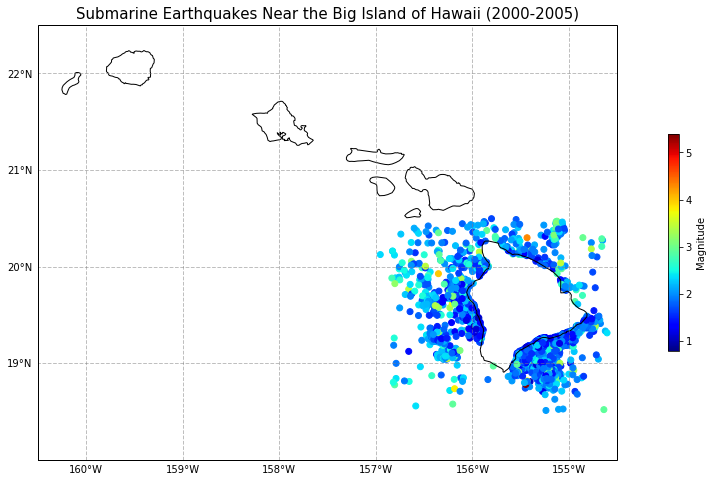

In [11]:
# Visualize Submarine Earthquakes Only

fig, axes = plt.subplots(figsize=(18, 8), ncols=5, sharey = True)
ax = plt.axes(projection=ccrs.PlateCarree())
extent = [-160.5, -154.5, 18, 22.5]
ax.set_extent(extent)
ax.set_xlabel('Longitude')
ax.set_title('Submarine Earthquakes Near the Big Island of Hawaii (2000-2005)', size=15)
ax.coastlines(resolution='10m')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels = True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator([-161, -160, -159, - 158, -157, -156, -155, -154])
gl.ylocator = mticker.FixedLocator([18, 19, 20, 21, 22, 23])
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

gl1 = ax.scatter(BI_ocean_events.Longitude, BI_ocean_events.Latitude, c=BI_ocean_events.Magnitude, cmap='jet', transform=ccrs.PlateCarree())

h = plt.colorbar(gl1, shrink=0.5)
h.set_label('Magnitude')

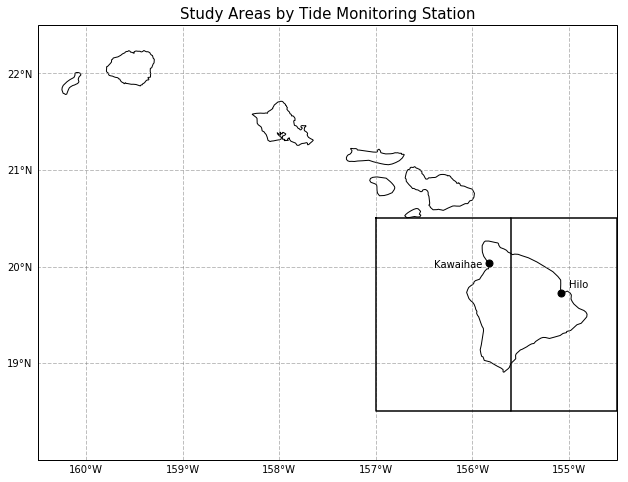

In [12]:
# Visualize Submarine Earthquakes Only

fig, axes = plt.subplots(figsize=(18, 8), ncols=5, sharey = True)
ax = plt.axes(projection=ccrs.PlateCarree())
extent = [-160.5, -154.5, 18, 22.5]
ax.set_extent(extent)
ax.set_xlabel('Longitude')
ax.set_title('Study Areas by Tide Monitoring Station', size=15)
ax.coastlines(resolution='10m')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels = True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator([-161, -160, -159, - 158, -157, -156, -155, -154])
gl.ylocator = mticker.FixedLocator([18, 19, 20, 21, 22, 23])
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.plot(-155.8282, 20.0353, 'ko', markersize=7, transform=ccrs.PlateCarree())
ax.text(-156.4, 19.99, 'Kawaihae', transform=ccrs.PlateCarree())

ax.plot(-155.0868, 19.7241, 'ko', markersize=7, transform=ccrs.PlateCarree())
ax.text(-155, 19.78, 'Hilo', transform=ccrs.PlateCarree())

sao_lats = [20.5, 20.5, 18.5, 18.5, 20.5]
sao_lons = [-157, -155.6, -155.6, -157, -157]
ax.plot(sao_lons, sao_lats, color = 'k')

sat_lats = [20.5, 20.5, 18.5, 18.5]
sat_lons = [-155.6, -154.5, -154.5, -155.6]
ax.plot(sat_lons, sat_lats, color = 'k')


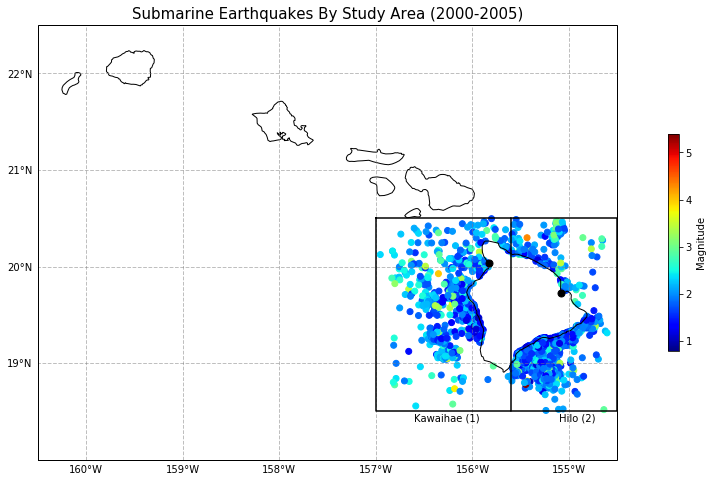

In [13]:
# Visualize Submarine Earthquakes By Study Area
fig, axes = plt.subplots(figsize=(18, 8), ncols=5, sharey = True)
ax = plt.axes(projection=ccrs.PlateCarree())
extent = [-160.5, -154.5, 18, 22.5]
ax.set_extent(extent)
ax.set_xlabel('Longitude')
ax.set_title('Submarine Earthquakes By Study Area (2000-2005)', size=15)
ax.coastlines(resolution='10m')

# Set Lat/Long Labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels = True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator([-161, -160, -159, - 158, -157, -156, -155, -154])
gl.ylocator = mticker.FixedLocator([18, 19, 20, 21, 22, 23])
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Plot Earthquakes
gl1 = ax.scatter(BI_ocean_events.Longitude, BI_ocean_events.Latitude, c=BI_ocean_events.Magnitude, cmap='jet', transform=ccrs.PlateCarree())

# Set Colorbar
h = plt.colorbar(gl1, shrink=0.5)
h.set_label('Magnitude')

# Locate Tide Stations
ax.plot(-155.8282, 20.0353, 'ko', markersize=7, transform=ccrs.PlateCarree())
ax.text(-156.6, 18.4, 'Kawaihae (1)', transform=ccrs.PlateCarree())
ax.plot(-155.0868, 19.7241, 'ko', markersize=7, transform=ccrs.PlateCarree())
ax.text(-155.1, 18.4, 'Hilo (2)', transform=ccrs.PlateCarree())

# Define Study Areas
sao_lats = [20.5, 20.5, 18.5, 18.5, 20.5]
sao_lons = [-157, -155.6, -155.6, -157, -157]
ax.plot(sao_lons, sao_lats, color = 'k')
sat_lats = [20.5, 20.5, 18.5, 18.5]
sat_lons = [-155.6, -154.5, -154.5, -155.6]
ax.plot(sat_lons, sat_lats, color = 'k')

### 5) Test for Tidal Triggering Component of Seismic Events

#### I will test the hypothesis that the mean of the tide heights during earthquakes is outside the range of what would be expected for completely independent events. The null hypothesis is that the new mean is not statistically different from the mean of all the tide data in the respective study areas.

In [14]:
# Define new dataframe with study area 1 earthquake and tide data
df = pd.DataFrame({'Mag': Kona_ocean_events['Magnitude'], 'Tide Height': Kawaihae_tide_data14['Tide Height (MLLW)']})

# Interpolate tide data to find tides during earthquakes
df['Tide Height'] = df['Tide Height'].interpolate('time')
Leeward_event_tides = df[df.Mag > 0]

# Define new dataframe with study area 2 earthquake and tide data
df2 = pd.DataFrame({'Mag': Hilo_ocean_events['Magnitude'], 'Tide Height': Hilo_tide_data14['Tide Height (MLLW)']})

# Interpolate tide data to find tides during earthquakes
df2['Tide Height'] = df2['Tide Height'].interpolate()
Windward_event_tides = df2[df2.Mag > 0]

In [15]:
# Describe Kawaihae Tide Data
Kawaihae_tide_data14.describe()

,Tide Height (MLLW)
count,52608.000000
mean,1077.259371
std,218.191274
min,506.000000
25%,914.000000
50%,1043.000000
75%,1223.000000
max,1835.000000


In [16]:
# Describe Tides during Study Area 1 Earthquakes
Leeward_event_tides.describe()

,Mag,Tide Height
count,653.000000,653.000000
mean,2.001639,1071.354830
std,0.492865,220.471844
min,0.860000,587.893500
25%,1.670000,904.959700
50%,1.950000,1025.687653
75%,2.300000,1206.092933
max,4.000000,1668.959625


In [17]:
# Describe Hilo Tide Data
Hilo_tide_data14.describe()

,Tide Height (MLLW)
count,52608.000000
mean,1102.204722
std,223.661423
min,441.000000
25%,950.000000
50%,1095.000000
75%,1255.000000
max,1776.000000


In [18]:
# Describe Tides during Study Area 1 Earthquakes
Windward_event_tides.describe()

,Mag,Tide Height
count,1924.000000,1924.000000
mean,1.897037,1098.149168
std,0.482471,222.367060
min,0.780000,557.666667
25%,1.580000,941.250000
50%,1.820000,1097.500000
75%,2.120000,1248.125000
max,5.400000,1703.500000


In [19]:
# Set Up One Sample Z-Test for Study Area 1
x_bar = Leeward_event_tides['Tide Height'].mean()
mu = Kawaihae_tide_data14['Tide Height (MLLW)'].mean()
sigma = Kawaihae_tide_data14['Tide Height (MLLW)'].std()
n = Leeward_event_tides['Tide Height'].size

Z_sample = (x_bar - mu)/(sigma*((n**2)))

#Calculate probability of Z_sample
norm.cdf(Z_sample)

0.49999997468182183

In [20]:
# Set Up One Sample Z-Test for Study Area 2
x_bar2 = Windward_event_tides['Tide Height'].mean()
mu2 = Hilo_tide_data14['Tide Height (MLLW)'].mean()
sigma2 = Hilo_tide_data14['Tide Height (MLLW)'].std()
n2 = Windward_event_tides['Tide Height'].size

Z_sample2 = (x_bar2 - mu2)/(sigma2*((n2**2)))

#Calculate probability of Z_sample2
norm.cdf(Z_sample2)

0.4999999980458452

### 6) Conclusions
#### In both study area 1 and study area 2, the results were not significant at any level. I have failed to detect any tidally triggered component of seismicity for marine earthquakes off the coast of the Big Island of Hawaii.